# Set up

In [17]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Masking, BatchNormalization, Dropout, Bidirectional
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
## Constants
# DATA_PATH = "/content/drive/MyDrive/Sophomore/ESE 3600/Project/data"
# LABELS_PATH = "/content/drive/MyDrive/Sophomore/ESE 3600/Project/labels.txt"
DATA_PATH = "./data"
LABELS_PATH = "./labels.txt"
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 1
NUM_EPOCHS = 10
REP_DATA_SIZE = 100
ORIG_MODEL_PATH = 'model.h5'
FLOAT_MODEL_PATH = 'tflite_model.tflite'
QUANTIZED_MODEL_PATH = 'tflite_micro_model.tflite'

# label2idx = {
#     'left_slow': 0,
#     'left_good': 1,
#     'left_fast': 2,
#     'right_slow': 3,
#     'right_good': 4,
#     'right_fast': 5,
#     'straight_slow': 6,
#     'straight_good': 7,
#     'straight_fast': 8,
# }

# text2label = {
#     'straight good': 'straight_good',
#     'straight slow': 'straight_slow',
#     'straight fast': 'straight_fast',
#     'left good': 'left_good',
#     'left slow': 'left_slow',
#     'left fast': 'left_fast',
#     'right good': 'right_good',
#     'right slow': 'right_slow',
#     'right fast': 'right_fast',
# }
label2idx = {
    'slow': 0,
    'good': 1,
    'fast': 2,
}

text2label = {
    'straight good': 'good',
    'straight slow': 'slow',
    'straight fast': 'fast',
    'left good': 'good',
    'left slow': 'slow',
    'left fast': 'fast',
    'right good': 'good',
    'right slow': 'slow',
    'right fast': 'fast',
}

NUM_LABELS = 3

# Data Processing

In [19]:
def load_data_samples(directory):
    data_samples = []

    ## Convert string to float
    def clean_and_convert(value):
        try:
            return float(value.split()[0])
        except ValueError:
            return None

    # Iterate over all files in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):
            file_path = os.path.join(directory, file_name)

            with open(file_path, 'r') as file:
                lines = file.readlines()

                sample_data = []
                for i in range(0, len(lines), 3):
                    # Extract Acceleration data
                    acc_line = lines[i].strip()
                    acc_values = []
                    for x in acc_line.split(','):
                        parts = x.split(':')
                        acc_values.append(clean_and_convert(parts[1].strip()))

                    # Extract Rotation data
                    if i + 1 < len(lines):
                        rot_line = lines[i + 1].strip()
                        rot_values = []
                        for x in rot_line.split(','):
                            parts = x.split(':')
                            rot_values.append(clean_and_convert(parts[1].strip()))
                    else:
                        rot_values = [None, None, None]

                    sample_data.append(acc_values + rot_values)

                columns = ['acc_X', 'acc_Y', 'acc_Z', 'rot_X', 'rot_Y', 'rot_Z']
                data_samples.append(pd.DataFrame(sample_data, columns=columns))
    return data_samples


def get_speed_labels():
    """
    Extract speed labels from the labels file (slow, good, fast)
    """
    with open(LABELS_PATH, 'r') as file:
        lines = file.readlines()

    speed_labels = []
    for line in lines:
        cleaned_label = line.strip().lower()
        if 'slow' in cleaned_label:
            speed_labels.append('slow')
        elif 'fast' in cleaned_label:
            speed_labels.append('fast')
        elif 'good' in cleaned_label:
            speed_labels.append('good')
        else:
            print(f"Warning: Speed label not found in '{cleaned_label}'")
            speed_labels.append('unknown')
    return speed_labels


def get_multilabel_labels():
    labels = []

    with open(LABELS_PATH, 'r') as file:
        lines = file.readlines()

    for line in lines:
        # Initialize multi-label array [speed_up, speed_down, reduce_rotation, perfect]
        label = [0, 0, 0, 0]

        # Clean and standardize the input
        cleaned_label = line.strip().lower()

        # Perfect case - straight good
        if cleaned_label == 'straight good':
            label[3] = 1  # perfect

        # Speed cases
        if 'slow' in cleaned_label:
            label[0] = 1
        elif 'fast' in cleaned_label:
            label[1] = 1

        # Rotation cases
        if 'left' in cleaned_label or 'right' in cleaned_label:
            label[2] = 1

        labels.append(label)
    return np.array(labels)


## Get the data samples and labels
data_samples = load_data_samples(DATA_PATH)
labels = get_speed_labels()

## Convert the labels to integers
for i, sample in enumerate(data_samples):
    sample['label'] = -1 if labels[i] == 'bad' else label2idx.get(labels[i], -1)


## Remove the rows with bad labels
final_data_samples = []
for sample in data_samples:
    if sample['label'].iloc[0] != -1:
        final_data_samples.append(sample)


### For multi-label classification
# for i, sample in enumerate(data_samples):
#     # Get the multi-label array for this sample
#     multi_label = labels[i]  # This is already in the format [speed_up, speed_down, reduce_rotation, perfect]
#     sample['labels'] = pd.Series([multi_label] * len(sample))  # Broadcast the labels to all rows

# ## Remove any invalid samples (if needed)
# final_data_samples = []
# for sample in data_samples:
#     label_array = sample['labels'].iloc[0]
#     if not all(l == 0 for l in label_array):
#         final_data_samples.append(sample)

print(f"Number of data samples: {len(final_data_samples)}")

Number of data samples: 113


# Data Engineering

Processed 113 samples

Feature Statistics:
       backswing_duration  forward_swing_duration  tempo_ratio  \
count          113.000000              113.000000   113.000000   
mean             2.734513                4.123894     0.764572   
std              1.772900                2.686383     0.428924   
min              1.000000                2.000000     0.083333   
25%              2.000000                2.000000     0.461538   
50%              2.000000                3.000000     0.666667   
75%              3.000000                5.000000     1.000000   
max              9.000000               14.000000     2.000000   

       max_acceleration  mean_acceleration  std_acceleration  backswing_max  \
count        113.000000         113.000000        113.000000     113.000000   
mean          17.493944          10.598732          1.390068      10.054088   
std            5.532639           0.422249          0.796234       0.508032   
min           11.358847           9.974268    

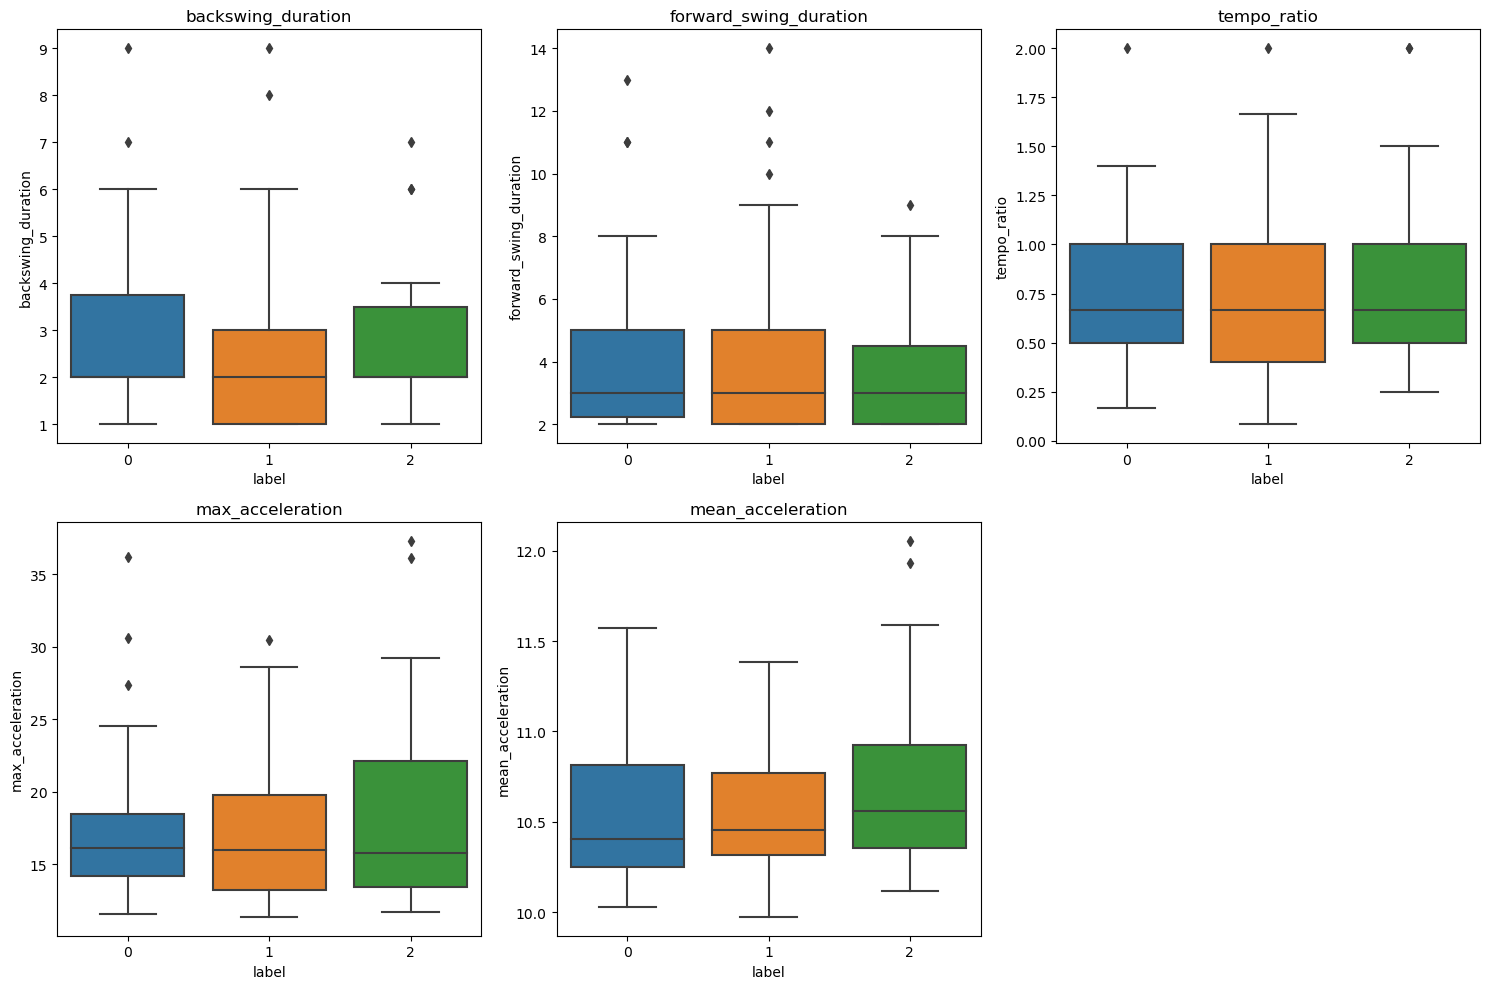

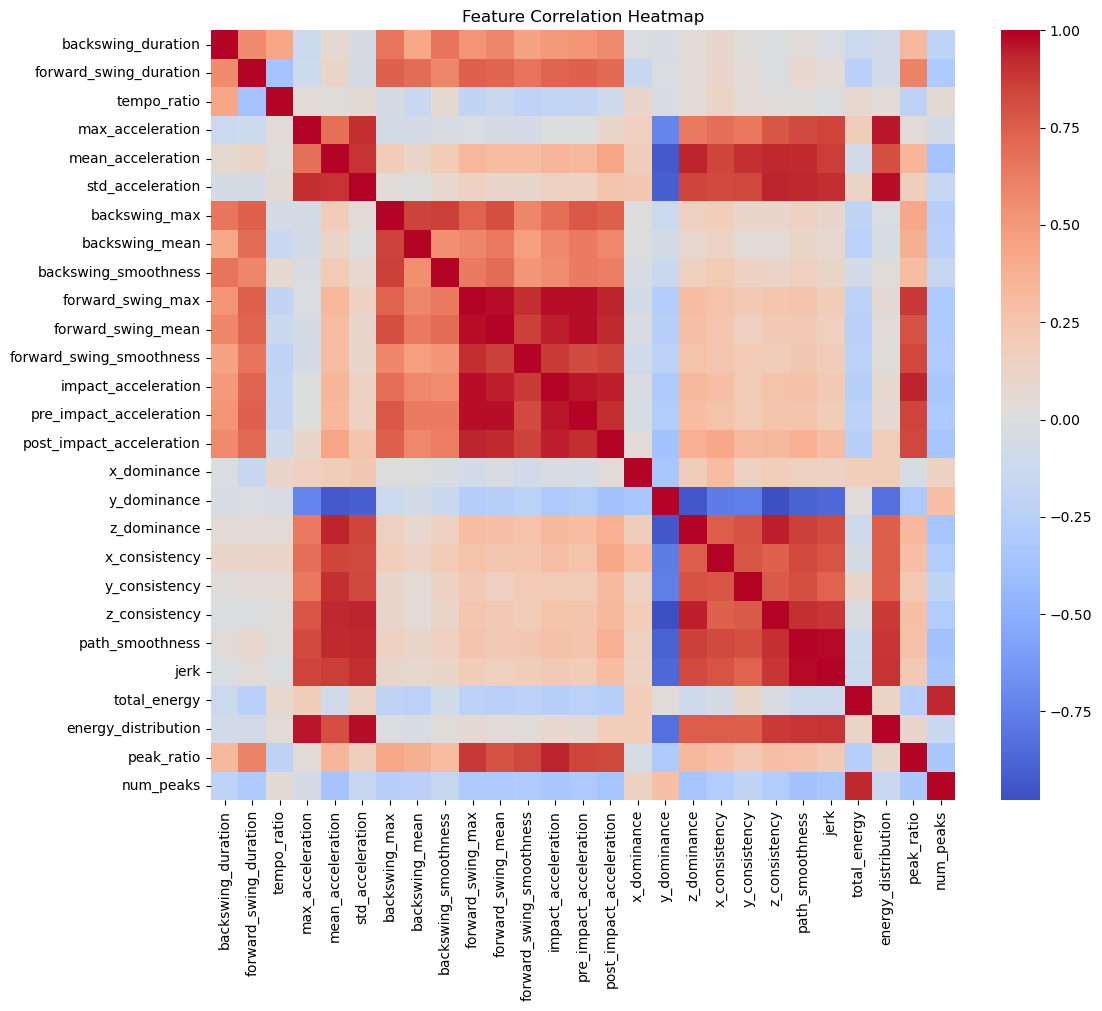

In [20]:
def extract_acceleration_features(data_list):
    """
    Extract metrics from the acceleration data for all samples
    """
    processed_features = []

    for data in data_list:
        # Calculate acceleration magnitude
        acc_magnitude = np.sqrt(data['acc_X']**2 + data['acc_Y']**2 + data['acc_Z']**2)

        # Find peaks in acceleration magnitude
        peaks, _ = find_peaks(acc_magnitude, height=np.std(acc_magnitude)*2)

        if len(peaks) < 2:
            continue  # Skip this sample if we can't find enough peaks

        # Find key points
        backswing_peak = peaks[0]  # First major peak (backswing to forward swing transition)
        impact_peak = peaks[1]     # Second major peak (impact)

        # Extract phases
        backswing = acc_magnitude[:backswing_peak]
        forward_swing = acc_magnitude[backswing_peak:impact_peak]
        follow_through = acc_magnitude[impact_peak:impact_peak+5]  # Limited follow-through

        # Calculate smoothness only if we have enough data points
        backswing_smoothness = np.std(np.gradient(backswing)) if len(backswing) > 2 else 0
        forward_swing_smoothness = np.std(np.gradient(forward_swing)) if len(forward_swing) > 2 else 0

        features = {
            # Timing features
            'backswing_duration': len(backswing),
            'forward_swing_duration': len(forward_swing),
            'tempo_ratio': len(backswing) / len(forward_swing) if len(forward_swing) > 0 else 0,

            # Magnitude features
            'max_acceleration': np.max(acc_magnitude),
            'mean_acceleration': np.mean(acc_magnitude),
            'std_acceleration': np.std(acc_magnitude),

            # Backswing features
            'backswing_max': np.max(backswing) if len(backswing) > 0 else 0,
            'backswing_mean': np.mean(backswing) if len(backswing) > 0 else 0,
            'backswing_smoothness': backswing_smoothness,

            # Forward swing features
            'forward_swing_max': np.max(forward_swing) if len(forward_swing) > 0 else 0,
            'forward_swing_mean': np.mean(forward_swing) if len(forward_swing) > 0 else 0,
            'forward_swing_smoothness': forward_swing_smoothness,

            # Impact features
            'impact_acceleration': acc_magnitude[impact_peak],
            'pre_impact_acceleration': np.mean(acc_magnitude[max(0, impact_peak-3):impact_peak]),
            'post_impact_acceleration': np.mean(follow_through) if len(follow_through) > 0 else 0,

            # Directional features
            'x_dominance': np.mean(np.abs(data['acc_X'])) / np.mean(acc_magnitude),
            'y_dominance': np.mean(np.abs(data['acc_Y'])) / np.mean(acc_magnitude),
            'z_dominance': np.mean(np.abs(data['acc_Z'])) / np.mean(acc_magnitude),

            # Consistency features
            'x_consistency': np.std(data['acc_X']),
            'y_consistency': np.std(data['acc_Y']),
            'z_consistency': np.std(data['acc_Z']),

            # Path smoothness (with checks)
            'path_smoothness': np.mean(np.abs(np.gradient(acc_magnitude))) if len(acc_magnitude) > 2 else 0,
            'jerk': np.mean(np.abs(np.gradient(np.gradient(acc_magnitude)))) if len(acc_magnitude) > 3 else 0,

            # Energy metrics
            'total_energy': np.sum(acc_magnitude**2),
            'energy_distribution': np.std(acc_magnitude**2),

            # Peak metrics
            'peak_ratio': acc_magnitude[impact_peak] / acc_magnitude[backswing_peak] if acc_magnitude[backswing_peak] > 0 else 0,
            'num_peaks': len(peaks),

            # Add label
            'label': data['label'].iloc[0]
        }

        processed_features.append(features)

    # Convert to DataFrame
    feature_df = pd.DataFrame(processed_features)

    # Print summary statistics
    print(f"Processed {len(processed_features)} samples")
    print("\nFeature Statistics:")
    print(feature_df.describe())

    # Plot feature distributions
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(feature_df.columns[:5]):  # Plot first 5 features
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='label', y=column, data=feature_df)
        plt.title(column)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(feature_df.drop('label', axis=1).corr(), cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

    return feature_df


acc_data_df = extract_acceleration_features(final_data_samples)

## Data Augmentation


Augmentation Results:
Original class distribution:
1    40
2    39
0    34
Name: label, dtype: int64

Augmented class distribution:
1    160
2    156
0    136
Name: label, dtype: int64


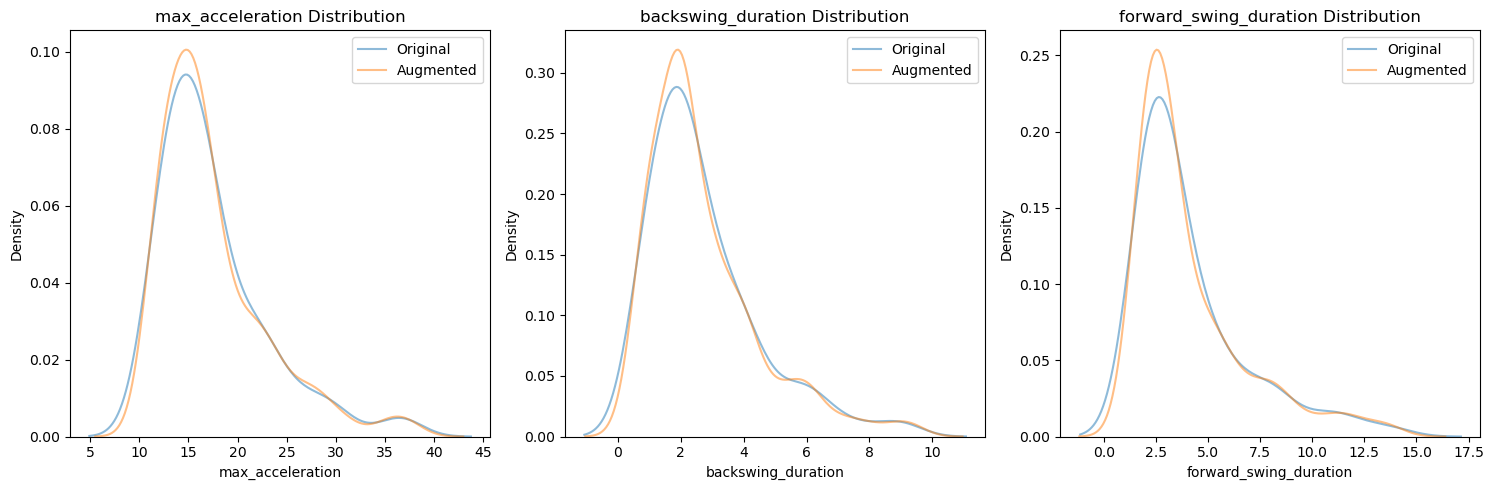

In [21]:
def augment_features(feature_df, num_augmentations=2):
    """
    Augment feature data by adding noise and scaling
    """
    # Get features and labels
    X = feature_df.drop('label', axis=1)
    y = feature_df['label']

    # Initialize lists for augmented data
    augmented_features = [X.copy()]
    augmented_labels = [y.copy()]

    # For each class
    for label in y.unique():
        # Get indices for this class
        class_indices = y[y == label].index

        # For each sample in this class
        for idx in class_indices:
            original_sample = X.loc[idx]

            # Create fixed number of augmentations for each sample
            for _ in range(num_augmentations):
                augmented_sample = original_sample.copy()

                # Add random noise to each feature
                for column in X.columns:
                    feature_std = X[column].std()
                    noise = np.random.normal(0, 0.1 * feature_std)
                    augmented_sample[column] += noise

                # Random scaling of timing features
                timing_features = ['backswing_duration', 'forward_swing_duration']
                scale = np.random.uniform(0.95, 1.05)
                for feat in timing_features:
                    if feat in augmented_sample.index:
                        augmented_sample[feat] *= scale

                # Random scaling of acceleration features
                acc_features = [col for col in X.columns if 'acceleration' in col]
                scale = np.random.uniform(0.95, 1.05)
                for feat in acc_features:
                    if feat in augmented_sample.index:
                        augmented_sample[feat] *= scale

                # Add augmented sample
                augmented_features.append(pd.DataFrame([augmented_sample]))
                augmented_labels.append(pd.Series([label]))

    # Combine all augmented data
    X_augmented = pd.concat(augmented_features, ignore_index=True)
    y_augmented = pd.concat(augmented_labels, ignore_index=True)

    # Combine into final dataframe
    final_df = pd.concat([X_augmented, y_augmented.rename('label')], axis=1)

    # Print augmentation results
    print("\nAugmentation Results:")
    print("Original class distribution:")
    print(y.value_counts())
    print("\nAugmented class distribution:")
    print(final_df['label'].value_counts())

    # Visualize distribution of features before and after augmentation
    plt.figure(figsize=(15, 5))

    # Plot first few important features
    important_features = ['max_acceleration', 'backswing_duration', 'forward_swing_duration']
    for i, feature in enumerate(important_features):
        plt.subplot(1, 3, i+1)

        # Original distribution
        sns.kdeplot(data=feature_df, x=feature, label='Original', alpha=0.5)
        # Augmented distribution
        sns.kdeplot(data=final_df, x=feature, label='Augmented', alpha=0.5)

        plt.title(f'{feature} Distribution')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return final_df

augmented_data_df = augment_features(acc_data_df, num_augmentations=3)

In [114]:
## Split acc_data_df into training, validation, and testing sets
# train_df, val_df, test_df = np.split(acc_data_df.sample(frac=1, random_state=42), [int(.6*len(acc_data_df)), int(.8*len(acc_data_df))])

# print(f"Training set size: {len(train_df)}")
# print(f"Validation set size: {len(val_df)}")
# print(f"Testing set size: {len(test_df)}")

# augmented_data_df = augment_features(train_df, num_augmentations=4)
# print(f"Augmented training set size: {len(augmented_data_df)}")

# Building Model

In [22]:
def create_nn_model(input_shape, num_labels=3):
    """
    Create a neural network model with more stable training
    """
    model = Sequential([
        # Input layer
        Dense(32, activation='relu', input_shape=input_shape,
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),  # Reduced dropout

        # Hidden layer
        Dense(16, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(num_labels, activation='softmax')
    ])

    # Adjusted learning rate
    learning_rate = 1e-4  # Reduced learning rate
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,      # Default momentum
        beta_2=0.999,    # Default decay
        epsilon=1e-7,    # Slightly smaller epsilon
        clipnorm=1.0     # Gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training model

In [23]:
def split_data(data_df):
    """
    Split data into training, validation, and testing sets
    """
    X = data_df.drop('label', axis=1).values
    y = data_df['label'].values

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(augmented_data_df)

In [24]:
def train_feature_model(X_train, X_val, X_test, y_train, y_val, y_test, epochs=200, batch_size=32):
    """
    Train the model using the extracted features with adjusted class weights
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Calculate class weights with stronger penalty for "Fast" class
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Adjust weights to penalize "Fast" predictions more
    # # Assuming classes are [0: 'Slow', 1: 'Good', 2: 'Fast']
    class_weight_dict[2] *= 1.5  # Increase weight for "Fast" class
    class_weight_dict[1] *= 1.2  # Slightly increase weight for "Good" class

    print("\nAdjusted class weights:", class_weight_dict)

    # Create model
    model = create_nn_model(input_shape=(X_train.shape[1],))

    # Callbacks with adjusted patience
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=25,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_feature_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        shuffle=True,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on test set with detailed analysis
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print("\nClassification Report:")
    label_names = ['Slow', 'Good', 'Fast']
    print(classification_report(y_test, y_pred_classes, target_names=label_names))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print misclassification analysis
    print("\nMisclassification Analysis:")
    for true_label, pred_label in zip(y_test, y_pred_classes):
        if true_label != pred_label:
            print(f"True: {label_names[true_label]} -> Predicted: {label_names[pred_label]}")

    return model, scaler, history


Adjusted class weights: {0: 1.103448275862069, 1: 1.1294117647058823, 2: 1.4545454545454546}
Epoch 1/200
1/9 [==>...........................] - ETA: 5s - loss: 3.2777 - accuracy: 0.3438
Epoch 1: val_loss improved from inf to 2.50041, saving model to best_feature_model.h5
9/9 [==============================] - 1s 29ms/step - loss: 3.3160 - accuracy: 0.2674 - val_loss: 2.5004 - val_accuracy: 0.3425 - lr: 1.0000e-04
Epoch 2/200
1/9 [==>...........................] - ETA: 0s - loss: 3.0039 - accuracy: 0.2812
Epoch 2: val_loss improved from 2.50041 to 2.45723, saving model to best_feature_model.h5
9/9 [==============================] - 0s 8ms/step - loss: 3.2972 - accuracy: 0.3160 - val_loss: 2.4572 - val_accuracy: 0.3288 - lr: 1.0000e-04
Epoch 3/200
1/9 [==>...........................] - ETA: 0s - loss: 2.7840 - accuracy: 0.3125
Epoch 3: val_loss improved from 2.45723 to 2.41632, saving model to best_feature_model.h5
9/9 [==============================] - 0s 7ms/step - loss: 3.1179 - accu

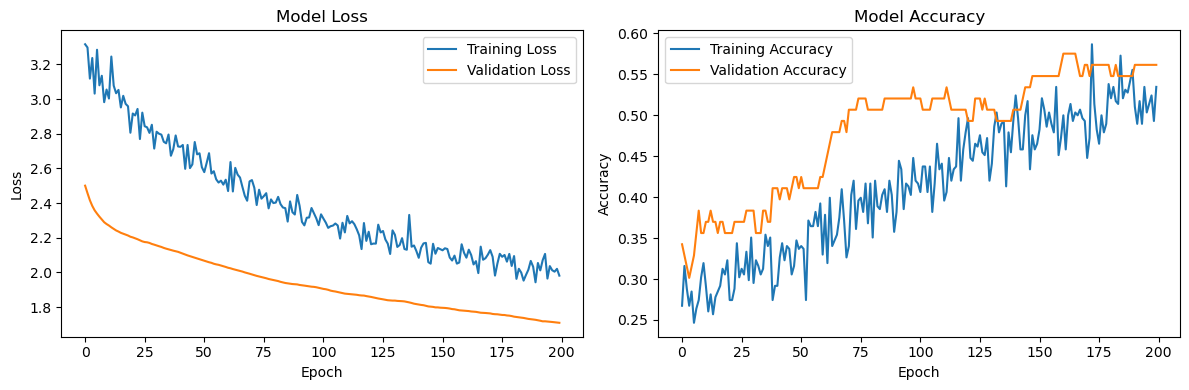

3/3 [==============================] - 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

        Slow       0.64      0.33      0.44        27
        Good       0.65      0.47      0.55        32
        Fast       0.54      0.91      0.67        32

    accuracy                           0.58        91
   macro avg       0.61      0.57      0.55        91
weighted avg       0.61      0.58      0.56        91



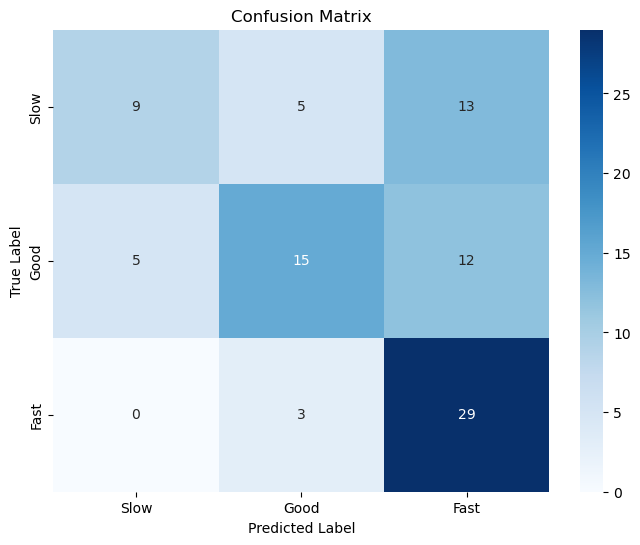


Misclassification Analysis:
True: Good -> Predicted: Slow
True: Good -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Good -> Predicted: Fast
True: Good -> Predicted: Slow
True: Slow -> Predicted: Fast
True: Fast -> Predicted: Good
True: Fast -> Predicted: Good
True: Good -> Predicted: Fast
True: Good -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Good -> Predicted: Fast
True: Fast -> Predicted: Good
True: Good -> Predicted: Fast
True: Slow -> Predicted: Good
True: Good -> Predicted: Fast
True: Slow -> Predicted: Good
True: Slow -> Predicted: Fast
True: Good -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Good -> Predicted: Fast
True: Slow -> Predicted: Fast
True: Slow -> Predicted: Good
True: Good -> Predicted: Slow
True: Slow -> Predicted: Fast
True: Good -> Predicted: Slow
True: Good -> Predicted: Fast
True: Slow -> Predicted: Good
True: Good 

In [25]:
# Run the training function
model, scaler, history = train_feature_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [27]:
## Save the model
model.save('model.h5')

## Remove correlated features

In [ ]:
# def plot_feature_heatmap(data_samples):
#     """
#     Create a correlation heatmap of features
#     """
#     # Combine all samples into one DataFrame
#     all_features = pd.concat([sample.drop('label', axis=1) for sample in data_samples])

#     # Calculate correlation matrix
#     corr_matrix = all_features.corr()

#     # Create heatmap
#     plt.figure(figsize=(15, 12))
#     sns.heatmap(corr_matrix,
#                 annot=True,
#                 cmap='coolwarm',
#                 center=0,
#                 fmt='.2f',
#                 square=True,
#                 linewidths=0.5)

#     plt.title('Feature Correlation Heatmap')
#     plt.tight_layout()
#     plt.show()

#     # Print the most correlated features
#     print("\nMost correlated feature pairs:")
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#     high_corr = [(corr_matrix.index[i], corr_matrix.columns[j], upper.iloc[i,j])
#                  for i, j in zip(*np.where(np.abs(upper) > 0.5))]
#     high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
#     for feat1, feat2, corr in high_corr[:10]:
#         print(f"{feat1} -- {feat2}: {corr:.3f}")

# plot_feature_heatmap(engineered_data_list)

In [ ]:
# def remove_uncorrelated_features(data_samples, correlation_threshold=0.1, correlation_with_others_threshold=0.9):
#     """
#     Remove features that are:
#     1. Weakly correlated with the target (label)
#     2. Highly correlated with other features (redundant)

#     Parameters:
#     - correlation_threshold: minimum correlation with target to keep feature
#     - correlation_with_others_threshold: maximum correlation with other features to keep feature
#     """
#     # Combine all samples into one DataFrame
#     all_features = pd.concat([sample.drop('label', axis=1) for sample in data_samples])
#     all_labels = pd.concat([sample['label'] for sample in data_samples])

#     # Calculate correlation matrix
#     corr_matrix = all_features.corr()

#     # Calculate correlation with target
#     target_corr = pd.DataFrame()
#     for column in all_features.columns:
#         target_corr.loc[column, 'target_correlation'] = abs(all_features[column].corr(all_labels))

#     # Find features with low correlation with target
#     low_corr_features = target_corr[target_corr['target_correlation'] < correlation_threshold].index.tolist()

#     print(f"\nFeatures with correlation < {correlation_threshold} with target:")
#     print(low_corr_features)

#     # Find highly correlated feature pairs
#     high_corr_features = set()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > correlation_with_others_threshold:
#                 feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
#                 # Keep the one with higher correlation with target
#                 if target_corr.loc[feat1, 'target_correlation'] > target_corr.loc[feat2, 'target_correlation']:
#                     high_corr_features.add(feat2)
#                 else:
#                     high_corr_features.add(feat1)

#     print(f"\nRedundant features (correlation > {correlation_with_others_threshold} with other features):")
#     print(list(high_corr_features))

#     # Combine features to remove
#     features_to_remove = set(low_corr_features) | high_corr_features
#     features_to_keep = [col for col in all_features.columns if col not in features_to_remove]

#     print(f"\nKeeping {len(features_to_keep)} features out of {len(all_features.columns)}")
#     print("\nFeatures to keep:")
#     print(features_to_keep)

#     # Create new dataset with selected features
#     cleaned_data_samples = []
#     for sample in data_samples:
#         cleaned_sample = sample[features_to_keep + ['label']].copy()
#         cleaned_data_samples.append(cleaned_sample)

#     # Plot correlation heatmap of remaining features
#     plt.figure(figsize=(12, 10))
#     cleaned_corr_matrix = pd.concat([sample.drop('label', axis=1) for sample in cleaned_data_samples]).corr()
#     sns.heatmap(cleaned_corr_matrix,
#                 annot=True,
#                 cmap='coolwarm',
#                 center=0,
#                 fmt='.2f',
#                 square=True,
#                 linewidths=0.5)
#     plt.title('Correlation Heatmap of Selected Features')
#     plt.tight_layout()
#     plt.show()

#     return cleaned_data_samples, features_to_keep

# # Use the function with more lenient thresholds
# cleaned_data_samples, selected_features = remove_uncorrelated_features(
#     engineered_data_list,
#     correlation_threshold=0.05,  # Lower threshold for correlation with target
#     correlation_with_others_threshold=0.95  # Higher threshold for correlation between features
# )

# # Print feature reduction summary
# print(f"\nReduced from {len(engineered_data_list[0].columns)-1} to {len(selected_features)} features")

# # Train model with cleaned data
# model, scaler, history = train_multiclass_putting_model(cleaned_data_samples)

# Quantize Model

In [37]:
def representative_dataset_gen():
    """Generate representative dataset with better coverage"""
    # Scale the data first
    scaled_data = scaler.transform(X_train)

    # Use more samples
    num_samples = min(500, len(X_train))

    # Ensure we have samples from all classes
    for class_idx in range(NUM_LABELS):
        class_mask = y_train == class_idx
        class_samples = scaled_data[class_mask]
        samples_per_class = min(num_samples // NUM_LABELS, len(class_samples))

        for i in range(samples_per_class):
            sample = class_samples[i:i+1].astype(np.float32)
            yield [sample]

In [36]:
# Load the original model
model = tf.keras.models.load_model(ORIG_MODEL_PATH)



# Convert to float TFLite model
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Save float model and print size
with open(FLOAT_MODEL_PATH, 'wb') as f:
    float_tflite_model_size = f.write(float_tflite_model)
print("Float model is %d bytes" % float_tflite_model_size)

INFO:tensorflow:Assets written to: /var/folders/qg/g7gs2bjn2llf1p8c229qrymw0000gn/T/tmp5s0642f7/assets


INFO:tensorflow:Assets written to: /var/folders/qg/g7gs2bjn2llf1p8c229qrymw0000gn/T/tmp5s0642f7/assets
/opt/homebrew/Caskroom/miniforge/base/envs/jupyter/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-12-08 10:45:03.808563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-08 10:45:03.808832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


ValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_dense_input:0 

In [33]:
# # Convert to quantized model with more optimizations
# quantized_converter = tf.lite.TFLiteConverter.from_keras_model(model)
# quantized_converter.optimizations = [tf.lite.Optimize.DEFAULT]
# quantized_converter.representative_dataset = representative_dataset_gen

# # Optional: Enforce full integer quantization
# quantized_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# quantized_converter.inference_input_type = tf.int8
# quantized_converter.inference_output_type = tf.int8

# # Convert and save quantized model
# tflite_quantized_model = quantized_converter.convert()
# with open(QUANTIZED_MODEL_PATH, 'wb') as f:
#     tflite_model_size = f.write(tflite_quantized_model)
# print("Quantized model is %d bytes" % tflite_model_size)
# print("Compression ratio: %f" % (float_tflite_model_size / tflite_model_size))
# Convert to quantized model with modified settings



quantized_converter = tf.lite.TFLiteConverter.from_keras_model(model)
quantized_converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_converter.representative_dataset = representative_dataset_gen

# Try using float16 quantization instead of int8
quantized_converter.target_spec.supported_types = [tf.float16]

# Remove the forced integer quantization
# quantized_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# quantized_converter.inference_input_type = tf.int8
# quantized_converter.inference_output_type = tf.int8

# Convert and save quantized model
tflite_quantized_model = quantized_converter.convert()
with open(QUANTIZED_MODEL_PATH, 'wb') as f:
    tflite_model_size = f.write(tflite_quantized_model)
print("Quantized model is %d bytes" % tflite_model_size)
print("Compression ratio: %f" % (float_tflite_model_size / tflite_model_size))

INFO:tensorflow:Assets written to: /var/folders/qg/g7gs2bjn2llf1p8c229qrymw0000gn/T/tmp57ckqx9l/assets


INFO:tensorflow:Assets written to: /var/folders/qg/g7gs2bjn2llf1p8c229qrymw0000gn/T/tmp57ckqx9l/assets


Quantized model is 6764 bytes
Compression ratio: 1.256062


2024-12-08 10:36:18.940539: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-08 10:36:18.941221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
/opt/homebrew/Caskroom/miniforge/base/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `


Quantized Model Accuracy: 0.2967

Classification Report:
              precision    recall  f1-score   support

        Slow       0.30      1.00      0.46        27
        Good       0.00      0.00      0.00        32
        Fast       0.00      0.00      0.00        32

    accuracy                           0.30        91
   macro avg       0.10      0.33      0.15        91
weighted avg       0.09      0.30      0.14        91



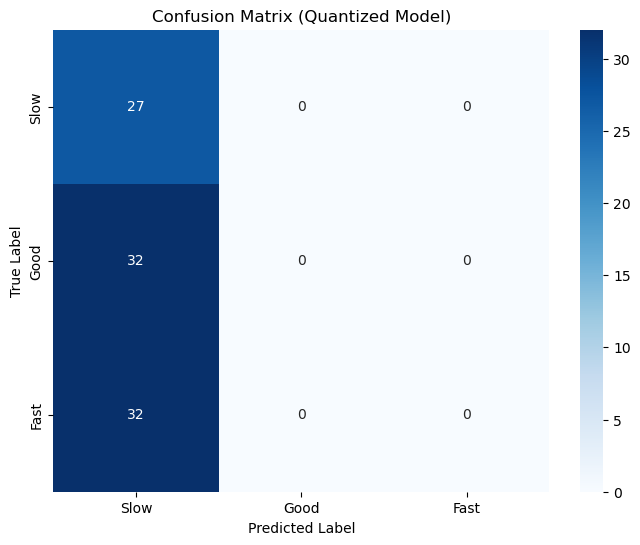

In [35]:
# # Evaluate quantized model accuracy
# interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
# interpreter.allocate_tensors()

# # Get input and output details
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Get quantization parameters
# input_scale, input_zero_point = input_details[0]["quantization"]
# output_scale, output_zero_point = output_details[0]["quantization"]

# # Initialize predictions list
# predictions = []
# correct = 0
# total = len(X_test)

# # Run inference on all test samples
# for i in range(total):
#     # Prepare and quantize input
#     test_sample = X_test[i:i+1].astype(np.float32)
#     test_sample_quantized = test_sample / input_scale + input_zero_point
#     test_sample_quantized = np.clip(test_sample_quantized, -128, 127).astype(np.int8)

#     # Set input tensor
#     interpreter.set_tensor(input_details[0]['index'], test_sample_quantized)

#     # Run inference
#     interpreter.invoke()

#     # Get and dequantize output
#     output = interpreter.get_tensor(output_details[0]['index'])
#     output_dequantized = (output.astype(np.float32) - output_zero_point) * output_scale

#     # Get predicted class
#     pred_class = np.argmax(output_dequantized)
#     predictions.append(pred_class)

#     # Check if prediction is correct
#     if pred_class == y_test[i]:
#         correct += 1

# # Calculate accuracy
# accuracy = correct / total

# # Print results
# print(f"\nQuantized Model Accuracy: {accuracy:.4f}")

# # Print classification report
# print("\nClassification Report:")
# label_names = ['Slow', 'Good', 'Fast']
# print(classification_report(y_test, predictions, target_names=label_names))

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# cm = confusion_matrix(y_test, predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=label_names,
#             yticklabels=label_names)
# plt.title('Confusion Matrix (Quantized Model)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()



# Evaluate quantized model accuracy
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Initialize predictions list
predictions = []
correct = 0
total = len(X_test)

# Run inference on all test samples
for i in range(total):
    # Prepare input - keep as float32 since that's what the model expects
    test_sample = X_test[i:i+1].astype(np.float32)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], test_sample)

    # Run inference
    interpreter.invoke()

    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])

    # Get predicted class
    pred_class = np.argmax(output[0])
    predictions.append(pred_class)

    # Check if prediction is correct
    if pred_class == y_test[i]:
        correct += 1

# Calculate accuracy
accuracy = correct / total

# Print results
print(f"\nQuantized Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
label_names = ['Slow', 'Good', 'Fast']
print(classification_report(y_test, predictions, target_names=label_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Confusion Matrix (Quantized Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
## Print out the model
MODEL_TFLITE = QUANTIZED_MODEL_PATH
MODEL_TFLITE_MICRO = 'tflite_micro_model.cc'


!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

sed: 1: "tflite_micro_model.cc": undefined label 'flite_micro_model.cc'


In [16]:
!cat {MODEL_TFLITE_MICRO}

unsigned char tflite_micro_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00,
  0x64, 0x08, 0x00, 0x00, 0x74, 0x08, 0x00, 0x00, 0x38, 0x12, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff,
  0x0a, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x39, 0x38, 0x00, 0x00, 0x00